In [167]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random

In [169]:
# Constants:
COOP = 1
DEF = 0
T = 5 
R = 3 
P = 2 
S = 1 

def distributePrize(me, them):
    if me == them == COOP:
        return R
    if (me == COOP) and (them == DEF):
        return S
    if (me == DEF) and (them == COOP):
        return T
    return P

## Rules:
### Cooperate Unconditionally (Cu)
Always cooperate
### Defect Unconditionally (Du)
Always defect
### Rand
Random choice
### Cooperate probability (Cp)
Cooperate a percentage of the time
### Tit for tat (TFT)
Starts with cooperate, then copies other players previous move
### Suspicious TFT (STFT)
TFT but starts with defect
### Gradual TFT (GrdTFT)
TFT, but every time they defect you defect, and if they defect multiple times you follow with a chain of defections equal to the number of times they defected. After this chain is finished, cooperate twice in a row as an apology

In [188]:
class Agent:
    def __init__(self):
        self.score = 0
        self.past = []
        self.againstAgentScore = {}
        self.againstAgentWins = {}
    
    def reset(self):
        self.score = 0
    
    def playMove(self, them, rn):
        return self.rule(them, rn)

    def addScore(self, result):
        self.score += result

    def getScore(self):
        return self.score

    def finishGame(self, score, outcome, enemy):
        # Outcome == 1 if won, 0 if lost
        self.againstAgentScore[enemy] = self.againstAgentScore.get(enemy, 0) + score
        self.againstAgentWins[enemy] = self.againstAgentWins.get(enemy, 0) + outcome

class Cu(Agent):
    def rule(self, them, rn):
        return COOP
    def __repr__(self):
        return "Cooperate unconditionally"

class Du(Agent):
    def rule(self, them, rn):
        return DEF
    def __repr__(self):
        return "Defect unconditionally"

class Rand(Agent):
    def rule(self, them, rn):
        return random.randint(0,2)
    def __repr__(self):
        return "Random"

class Cp(Agent):
    def rule(self, them, rn):
        if random.rand() >= .75:
            return COOP
        return DEF
    def __repr__(self):
        return "Cooperate probabilistically"

class TFT(Agent):
    def rule(self, them, rn):
        if rn == 0: return COOP
        else: return them[-1]
    def __repr__(self):
        return "Tit for Tat"

class STFT(Agent):
    def rule(self, them, rn):
        if rn == 0: return DEF
        return them[-1]
    def __repr__(self):
        return "Suspicious Tit for Tat"

In [214]:
class Arbiter:
    # Manages games between two agents
    def __init__(self, rounds):
        self.rounds = rounds
        self.overallscores = {}
        self.wins = {}
        self.agents = {}

    def playNMatches(self, a1, a2, N):
        self.agents.update({a1:a1})
        self.agents.update({a2:a2})
        for _ in range(N):
            self.playMatch(a1, a2)
    
    def playMatch(self, a1, a2):
        a1past = []
        a2past = []

        for n in range(self.rounds):
            a1past, a2past = self.playOneGame(a1, a1past, a2, a2past, n)

        a1score = a1.getScore()
        a2score = a2.getScore()
        self.overallscores[a1] = self.overallscores.get(a1, 0) + a1score
        self.overallscores[a2] = self.overallscores.get(a2, 0) + a2score

        a1win, a2win = 0, 0
        if a1score > a2score: a1win = 1
        else: a2win = 1
        self.wins[a1] = self.wins.get(a1, 0) + a1win
        self.wins[a2] = self.wins.get(a2, 0) + a2win
        a1.finishGame(a1score, a1win, a2)
        a2.finishGame(a2score, a2win, a1)
        
    def playOneGame(self, a1, a1past, a2, a2past, roundnum):
        m1 = a1.rule(a2past, roundnum)
        m2 = a2.rule(a1past, roundnum)
        a1past.append(m1)
        a2past.append(m2)
        a1.addScore(distributePrize(m1, m2))
        a2.addScore(distributePrize(m2, m1))
        return a1past, a2past

    def displayScores(self):
        print("Overall Scores: ",self.overallscores)
        for agent in self.agents:
            print(f"Agent {agent} score {self.overallscores[agent]}, broken up as: {agent.againstAgentScore}")
        print("Wins:", self.wins)

In [308]:
a1 = TFT()
a2 = Du()
a3 = Rand()
a4 = Cp()
arb = Arbiter(1000)

arb.playNMatches(a1, a2, 20)
arb.playNMatches(a1, a3, 20)
arb.playNMatches(a1, a4, 20)
arb.playNMatches(a2, a3, 20)
arb.playNMatches(a2, a4, 20)
arb.playNMatches(a3, a4, 20)
#arb.displayScores()

4318656.5
[-107133.5, 412595.5, -166942.5, -138519.5]
[4211523, 4731252, 4151714, 4180137]


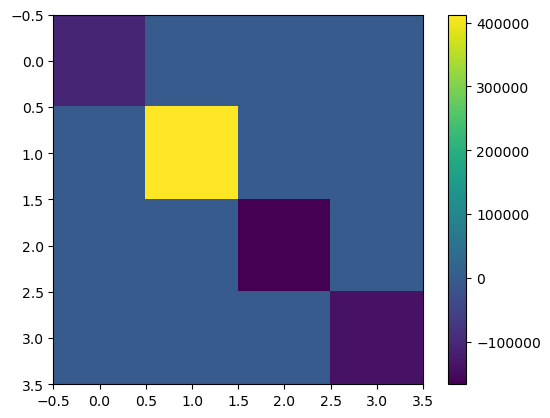

In [320]:
agents = [a1,a2,a3,a4]
scoreData = []
rawData = []
for agent in agents:
    rawData.append(arb.overallscores[agent])
average = np.average(rawData)
for score in rawData:
    scoreData.append((score-average))
print(average)
print(scoreData)
print(rawData)
grid = np.zeros((4,4))
grid[0,0] = scoreData[0]
grid[1,1] = scoreData[1]
grid[2,2] = scoreData[2]
grid[3,3] = scoreData[3]
plt.imshow(grid)
plt.colorbar()